In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Flatten

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report


In [2]:
data = pd.read_csv('AUD_CAD_rev.csv')
data = data[-100040:]

In [3]:
data.ws10_pt10_sl8.value_counts()


hold    38541
buy     32274
sell    29225
Name: ws10_pt10_sl8, dtype: int64

In [4]:
# string to index -1转换成正整数
REPLACE_INDEX = {'buy':0, 'hold':1, 'sell':2}
data.replace(REPLACE_INDEX, inplace= True)
# one hot label index
BUY_HOLD_SELL_INDEX = {'buy': [0,1,0,0], 'hold': [0,0,1,0], 'sell': [0,0,0,1]}


In [5]:
# remove all nan
print(f'before: {data.shape}')
data.dropna(subset=['min_40', 'ratio top'],inplace=True)
data = data.reset_index(drop=True)
# train val test split method 1
Xtrain = data[(data['datetime']>='2018-06-25T09:00:00.000000000Z') & ((data['datetime']<='2021-09-13T00:45:00.000000000Z'))]
Xtrain.reset_index(drop=True, inplace=True)
Xvalid = data[(data['datetime']>='2021-09-13T01:00:00.000000000Z') & ((data['datetime']<='2022-02-04T07:45:00.000000000Z'))]
Xvalid.reset_index(drop=True, inplace=True)
Xtest = data[(data['datetime']>='2022-02-04T08:00:00.000000000Z') & ((data['datetime']<='2022-06-30T13:30:00.000000000Z'))]
Xtest.reset_index(drop=True, inplace=True)
print(f'train size: {Xtrain.shape}\nvalidtion size: {Xvalid.shape}\ntest size: {Xtest.shape}')


before: (100040, 172)
train size: (80000, 172)
validtion size: (10000, 172)
test size: (10000, 172)


In [6]:
def generate_sequence(data, window_size):
    train_dt_ori, train_dt_scaled, target_minprice, target_maxprice, target_minp_scaled,\
    target_maxp_scaled, price_scaler_max, price_scaler_min = [], [], [], [], [], [], [], []

    train_dt_SO1 = []
    train_dt_SO2 = []
    train_dt_MA1 = []
    train_dt_MA2 = []
    train_dt_MA3 = []
    train_dt_MA4 = []
    
    train_dt_distance,target_bhs = [], []
    ta_indicators = []
    seqlen = window_size # 更改window size对应label！
    scaler = MinMaxScaler()
    scaler_a = MinMaxScaler()

    for index, row in data.iterrows(): 
        # 取前500行数据 正式训练取完整数据集
        if index <= len(data) - window_size:
            # OHLC numerical取值
            train_dt_ori.append(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].values)
            #  Categorical取值
            
            train_dt_SO1.append(data.loc[index:seqlen-1+index, ['SO1']].values)  
            train_dt_SO2.append(data.loc[index:seqlen-1+index, ['SO2']].values)  
            train_dt_MA1.append(data.loc[index:seqlen-1+index, ['label15,70']].values)  
            train_dt_MA2.append(data.loc[index:seqlen-1+index, ['label25,80']].values)  
            train_dt_MA3.append(data.loc[index:seqlen-1+index, ['label35,90']].values)  
            train_dt_MA4.append(data.loc[index:seqlen-1+index, ['label45,100']].values)  
            
            # TA indicators numerical取值
            ta_indicators.append(scaler_a.fit_transform(data.loc[index:seqlen-1+index, ['wr15', 'wr25','wr35','rsi15','rsi25','rsi35','atr15',\
               'atr25','atr35','STOCHk_14_3_3','STOCHd_14_3_3' ]].values))
            # windows size 内进行min max scale
            train_dt_scaled.append(scaler.fit_transform(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].values))

            # 每10个window size/seq length 预测 min_10 label
            tmp_minprice = data.loc[seqlen-1+index, f'min_{window_size}'].tolist()
            target_minprice.append(tmp_minprice)
            # 每10个window size/seq length 预测 max_10 label
            tmp_maxprice = data.loc[seqlen-1+index, f'max_{window_size}'].tolist()
            target_maxprice.append(tmp_maxprice)

            # 取值 不同参数下bhs label
            target_bhs.append(data.loc[seqlen-1+index, ['ws10_pt10_sl8']].values)

            # 当前ws seqlength最大最小值
            max_v = max(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].max())
            min_v = min(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].min())
            # 预测min_10 max_10 label 进行scaled 
            target_minp_scaled.append((tmp_minprice-min_v)/(max_v-min_v))
            target_maxp_scaled.append((tmp_maxprice-min_v)/(max_v-min_v))
            # 保存最大值 最小值 预测之后inverse transform orginal scale
            price_scaler_max.append(max_v)
            price_scaler_min.append(min_v)

    # 转换对应数据类型 np.array astype()
    train_arr_ohlc_scaled = np.array(train_dt_scaled).astype('float32')
    train_arr_SO1 = np.array(train_dt_SO1).astype('int64')
    train_arr_SO2 = np.array(train_dt_SO2).astype('int64')
    train_arr_MA1 = np.array(train_dt_MA1).astype('int64')
    train_arr_MA2 = np.array(train_dt_MA2).astype('int64')
    train_arr_MA3 = np.array(train_dt_MA3).astype('int64')
    train_arr_MA4 = np.array(train_dt_MA4).astype('int64')
    
    ta_indicators =  np.array(ta_indicators).astype('float32')
    target_minpArr_scaled = np.array(target_minp_scaled).astype('float32')
    target_maxpArr_scaled = np.array(target_maxp_scaled).astype('float32') 
    # one hot encoding label
    target_arr_bhs = np.array(target_bhs).astype('int64')
    # target_arr_bhs = to_categorical(target_bhs)
    
    # 训练集数据 名字要对应模型 {'OHLC' : np.array([ohlc])}
    train_x_dict = {'OHLC':train_arr_ohlc_scaled,'SO1': train_arr_SO1,'SO2':train_arr_SO2,'MA1': train_arr_MA1,'MA2':train_arr_MA2,'MA3': train_arr_MA3,'MA4':train_arr_MA4, "TAINDICATORS" : ta_indicators}
    train_y_dict = {'minp': target_minpArr_scaled, 'maxp': target_maxpArr_scaled, 'bhs':target_arr_bhs}
    
    return train_x_dict,train_y_dict, price_scaler_max,price_scaler_min,target_minprice, target_maxprice



In [8]:
# 训练集
train_x_dict,train_y_dict,price_scaler_max,price_scaler_min,train_minprice, train_maxprice = generate_sequence(Xtrain,10)
# 验证集
valid_x_dict,valid_y_dict,val_price_scaler_max,val_price_scaler_min,valid_minprice, valid_maxprice = generate_sequence(Xvalid,10)
# 测试集
test_x_dict,test_y_dict,test_price_scaler_max,test_price_scaler_min,test_minprice, test_maxprice = generate_sequence(Xtest,10)

In [9]:
# LSTM model
def buildModel(seqlen, EMBED_DIM=64): 
    # feature input对应name 和 dtype
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')

    input_so1 = layers.Input((seqlen,), dtype=tf.int64, name='SO1')
    input_so2 = layers.Input((seqlen,), dtype=tf.int64, name='SO2')
    input_ma1 = layers.Input((seqlen,), dtype=tf.int64, name='MA1')
    input_ma2 = layers.Input((seqlen,), dtype=tf.int64, name='MA2')
    input_ma3 = layers.Input((seqlen,), dtype=tf.int64, name='MA3')
    input_ma4 = layers.Input((seqlen,), dtype=tf.int64, name='MA4')
    input_indicator = layers.Input((seqlen,11), dtype=tf.float32, name='TAINDICATORS')


    # categorical embedding layer (input_dim = 类别+1)
    emb_so1 = layers.Embedding(6, EMBED_DIM, name='so1_embedding')(input_so1)
    emb_so2 = layers.Embedding(6, EMBED_DIM, name='so2_embedding')(input_so2)
    emb_ma1 = layers.Embedding(3, EMBED_DIM, name='ma1_embedding')(input_ma1)
    emb_ma2 = layers.Embedding(3, EMBED_DIM, name='ma2_embedding')(input_ma2)
    emb_ma3 = layers.Embedding(3, EMBED_DIM, name='ma3_embedding')(input_ma3)
    emb_ma4 = layers.Embedding(3, EMBED_DIM, name='ma4_embedding')(input_ma4)
    
    # input feature输入进模型 尽量对应顺序
    
    features_so1 = layers.LSTM(128,dropout=0.2)(emb_so1)
    features_so2 = layers.LSTM(128,dropout=0.2)(emb_so2)
    features_ma1 = layers.LSTM(128,dropout=0.2)(emb_ma1)
    features_ma2 = layers.LSTM(128,dropout=0.2)(emb_ma2)
    features_ma3 = layers.LSTM(128,dropout=0.2)(emb_ma3)
    features_ma4 = layers.LSTM(128,dropout=0.2)(emb_ma4)
    
    features_ohlc = layers.LSTM(128,dropout=0.2, return_sequences=False)(input_ohlc)
    feature_indicator = layers.LSTM(128,dropout=0.2)(input_indicator)


    features_all = layers.concatenate([features_ohlc,features_so1,features_so2,features_ma1,features_ma2,features_ma3,features_ma4,feature_indicator])
    # dropout, layernormalization 

    output_maxp = layers.Dense(1,name='maxp')(features_all)
    output_minp = layers.Dense(1,name='minp')(features_all)
    # one hot encoding 类别+1
    output_buyholdsell = layers.Dense(3, activation="softmax", name = 'bhs')(features_all)

    model = keras.Model(inputs=[input_ohlc,input_so1,input_so2,input_ma1,input_ma2,input_ma3,input_ma4,input_indicator],outputs=[output_maxp, output_minp,output_buyholdsell],)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=0.001),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            # categorical crossentropy 需要 one hot encoding
            # SparseCategoricalCrossentropy  label 输入为整数 
            'bhs' : 'SparseCategoricalCrossentropy',
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :'acc',
        }
    )
    model.summary()
    return model 

In [10]:
LSTM_model = buildModel(10)

2022-11-21 18:44:21.928444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 SO1 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 SO2 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 MA1 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 MA2 (InputLayer)               [(None, 10)]         0           []                               
                                                                                              

In [11]:
# Hyper parameter tuning 
history = LSTM_model.fit(train_x_dict, train_y_dict, epochs= 50, 
    batch_size=64,verbose = 1, validation_data=(valid_x_dict ,valid_y_dict) , shuffle = False)

Epoch 1/50
1250/1250 [==============================] - 97s 68ms/step - loss: 1.8023 - maxp_loss: 0.3372 - minp_loss: 0.3879 - bhs_loss: 1.0772 - maxp_root_mean_squared_error: 0.5807 - minp_root_mean_squared_error: 0.6228 - bhs_acc: 0.4131 - val_loss: 1.6490 - val_maxp_loss: 0.2522 - val_minp_loss: 0.2819 - val_bhs_loss: 1.1149 - val_maxp_root_mean_squared_error: 0.5022 - val_minp_root_mean_squared_error: 0.5309 - val_bhs_acc: 0.3750
Epoch 2/50
1250/1250 [==============================] - 81s 65ms/step - loss: 1.7383 - maxp_loss: 0.2989 - minp_loss: 0.3623 - bhs_loss: 1.0771 - maxp_root_mean_squared_error: 0.5467 - minp_root_mean_squared_error: 0.6019 - bhs_acc: 0.4165 - val_loss: 1.6216 - val_maxp_loss: 0.2423 - val_minp_loss: 0.2732 - val_bhs_loss: 1.1061 - val_maxp_root_mean_squared_error: 0.4923 - val_minp_root_mean_squared_error: 0.5227 - val_bhs_acc: 0.3752
Epoch 3/50
1250/1250 [==============================] - 83s 67ms/step - loss: 1.7301 - maxp_loss: 0.2940 - minp_loss: 0.3583

Epoch 20/50
1250/1250 [==============================] - 75s 60ms/step - loss: 1.7160 - maxp_loss: 0.2849 - minp_loss: 0.3492 - bhs_loss: 1.0819 - maxp_root_mean_squared_error: 0.5337 - minp_root_mean_squared_error: 0.5910 - bhs_acc: 0.4061 - val_loss: 1.5797 - val_maxp_loss: 0.2285 - val_minp_loss: 0.2611 - val_bhs_loss: 1.0902 - val_maxp_root_mean_squared_error: 0.4780 - val_minp_root_mean_squared_error: 0.5109 - val_bhs_acc: 0.3916
Epoch 21/50
1250/1250 [==============================] - 74s 59ms/step - loss: 1.7153 - maxp_loss: 0.2842 - minp_loss: 0.3492 - bhs_loss: 1.0818 - maxp_root_mean_squared_error: 0.5331 - minp_root_mean_squared_error: 0.5909 - bhs_acc: 0.4057 - val_loss: 1.5795 - val_maxp_loss: 0.2284 - val_minp_loss: 0.2609 - val_bhs_loss: 1.0902 - val_maxp_root_mean_squared_error: 0.4779 - val_minp_root_mean_squared_error: 0.5108 - val_bhs_acc: 0.3921
Epoch 22/50
1250/1250 [==============================] - 76s 60ms/step - loss: 1.7160 - maxp_loss: 0.2847 - minp_loss: 0.3

Epoch 39/50
1250/1250 [==============================] - 74s 59ms/step - loss: 1.7135 - maxp_loss: 0.2837 - minp_loss: 0.3481 - bhs_loss: 1.0817 - maxp_root_mean_squared_error: 0.5327 - minp_root_mean_squared_error: 0.5900 - bhs_acc: 0.4058 - val_loss: 1.5762 - val_maxp_loss: 0.2268 - val_minp_loss: 0.2595 - val_bhs_loss: 1.0899 - val_maxp_root_mean_squared_error: 0.4763 - val_minp_root_mean_squared_error: 0.5094 - val_bhs_acc: 0.3927
Epoch 40/50
1250/1250 [==============================] - 71s 57ms/step - loss: 1.7127 - maxp_loss: 0.2829 - minp_loss: 0.3478 - bhs_loss: 1.0819 - maxp_root_mean_squared_error: 0.5319 - minp_root_mean_squared_error: 0.5898 - bhs_acc: 0.4063 - val_loss: 1.5762 - val_maxp_loss: 0.2268 - val_minp_loss: 0.2595 - val_bhs_loss: 1.0899 - val_maxp_root_mean_squared_error: 0.4763 - val_minp_root_mean_squared_error: 0.5094 - val_bhs_acc: 0.3927
Epoch 41/50
1250/1250 [==============================] - 71s 57ms/step - loss: 1.7131 - maxp_loss: 0.2830 - minp_loss: 0.3

In [12]:
LSTM_model.save('lstm_audcad_e50_b64_w10.h5')

In [13]:
# 计算准确率
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):

    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()
    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')

    return mae, mape, mse, rmse

def inverse_buyholdsell_label(output_ls):
    # softmax vector 找到最大返回对应one hot矩阵
    temp = [0,0,0]
    idx = 0   
    for i in output_ls:
        if i == max(output_ls):
            temp[idx] = 1
        idx+=1
    return temp

    res = []
    for i in y_pred[2]:
      pre = inverse_buyholdsell_label(list(i))

      res.append(pre)


    #res
    ground_true = valid_y_dict['bhs']
    ground_true
    ground_true_matrix = to_categorical(ground_true)
    # print(f'Accuracy for predicting buy hold sell label: {accuracy_score(res, valid_y_dict['bhs']):.4f}')
    accuracy_score(res, ground_true_matrix)


# Predict 测试集数据
def visualize_result(model, train_x_dict, train_y_dict,price_scaler_min, price_scaler_max,train_minprice,train_maxprice):
    y_pred = model.predict(train_x_dict)
    print('-' * 100)
    print('MinMax Price Prediction Result: ')

    # max
    y_pred[0]
    # min
    y_pred[1]
    # buy hold sell label
    # y_pred[2]

    # Inverse prediction to orginal scale
    min_output,max_output = [],[]
    for i in range(len(y_pred[0])):
        #print(price_scaler_max[i] - price_scaler_min[i], y_pred[0][i] , price_scaler_min[i] )
        max_output.append( (y_pred[0][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )
        min_output.append( (y_pred[1][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )

    a,b,c,d =evaluate_regression_prediction(max_output,train_maxprice,'Model')
    a,b,c,d =evaluate_regression_prediction(min_output,train_minprice,'Model')


    # Prediction result on Test set
    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(max_output, label='Max Predict')
    #plt.plot(min_output, label='Min Predict')
    #plt.plot(train_minprice, label='Actual Min Price') 
    plt.plot(train_maxprice, label='Actual Max Price') 
    plt.title('Predict Max & Actual Max')
    plt.legend(loc = 'upper right')

    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(min_output, label='Min Predict')
    plt.plot(train_minprice, label='Actual Min Price') 
    plt.title('Predict Min & Actual Min')
    plt.legend(loc = 'upper right')

    # Inverse buy hold sell prediction label
    if len(y_pred) >2:
        res = []
        for i in y_pred[2]:
            pre = inverse_buyholdsell_label(list(i))
            res.append(pre)
        

        # res
        ground_true = valid_y_dict['bhs']
        ground_true
        ground_true_matrix = to_categorical(ground_true)
        # print(f'Accuracy for predicting buy hold sell label: {accuracy_score(res, valid_y_dict['bhs']):.4f}')
        # accuracy_score(res, ground_true_matrix)

        print(f'Accuracy for predicting buy hold sell label: {accuracy_score(ground_true_matrix,res):.4f}')
        print(classification_report(ground_true_matrix,res))
        print('-' * 100)


def visualize_history(history):
    # visual_loss = ['maxp_loss', 'minp_loss', 'bhs_loss','val_maxp_loss', 'val_minp_loss', 'val_bhs_loss']
    visual_loss = ['maxp_loss', 'minp_loss','val_maxp_loss', 'val_minp_loss']
    visual_acc = ['Train Accuracy', 'Validation Accuracy']

    plt.figure(2)
    plt.figure(figsize=(15,6))
    for i in visual_loss:
        history.history[i]
        plt.plot(history.epoch,history.history[i], label =i )
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')

    plt.figure(2)
    history.history[i]
    plt.bar(x = visual_acc, height = [history.history['bhs_acc'][-1],history.history['val_bhs_acc'][-1]] )
    plt.xlabel('Accuracy')
    plt.ylabel('Train & Validation')
    plt.title('Label BuyHoldSell Prediction Accuracy')
    plt.show()

313/313 [==============================] - 9s 16ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01044272
Mean Absolute Percentage Error: 1.14032592
Mean Square Error: 0.00016917
Root Mean Square Error: 0.01300645

Model:
Mean Absolute Error: 0.01048113
Mean Absolute Percentage Error: 1.14672964
Mean Square Error: 0.00017048
Root Mean Square Error: 0.01305694

Accuracy for predicting buy hold sell label: 0.3937
              precision    recall  f1-score   support

           0       0.39      0.22      0.28      3149
           1       0.40      0.86      0.54      3747
           2       0.10      0.00      0.00      3095

   micro avg       0.39      0.39      0.39      9991
   macro avg       0.29      0.36      0.27      9991
weighted avg       0.30      0.39      0.29      9991
 samples avg       0.39      0.39      0.39      9991

---------------------------

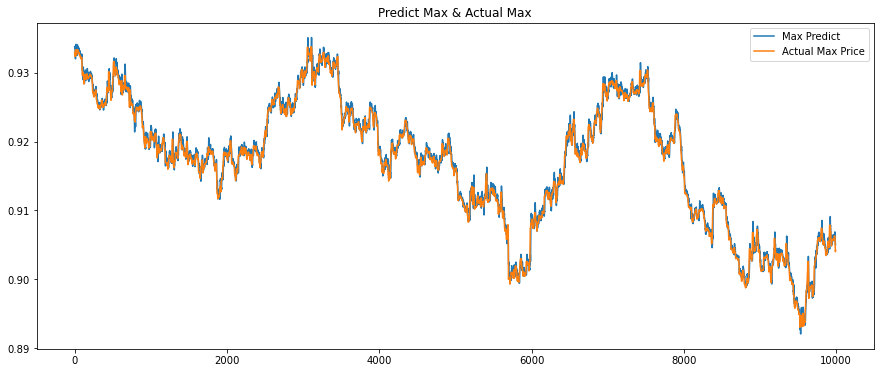

<Figure size 432x288 with 0 Axes>

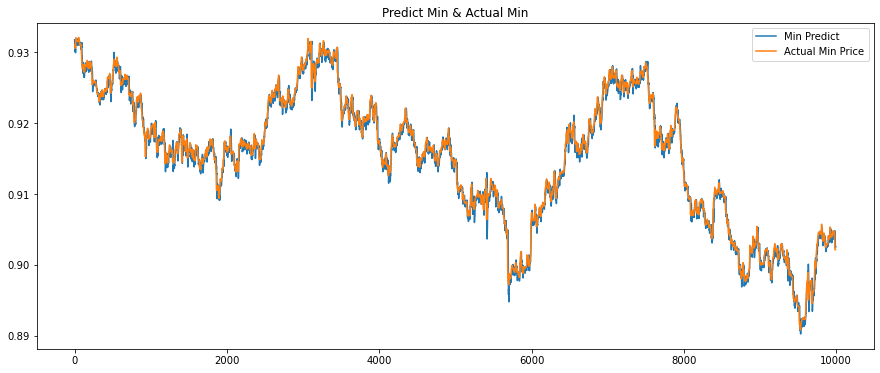

In [14]:
# one-step prediction on train set
visualize_result(LSTM_model,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)
# one-step prediction on test set
# visualize_result(LSTM_model,test_x_dict, test_price_scaler_min,test_price_scaler_max,test_minprice, test_maxprice)
# visualize_history(history)
# visualize_result(LSTM_model,test_x_dict,test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)

## Bi_LSTM

In [45]:
# LSTM model
def buildModel_Bi_LSTM(seqlen, EMBED_DIM=64): 
    # feature input对应name 和 dtype
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')
    input_so1 = layers.Input((seqlen,), dtype=tf.int64, name='SO1')
    input_so2 = layers.Input((seqlen,), dtype=tf.int64, name='SO2')
    
    input_ma1 = layers.Input((seqlen,), dtype=tf.int64, name='MA1')
    input_ma2 = layers.Input((seqlen,), dtype=tf.int64, name='MA2')
    input_ma3 = layers.Input((seqlen,), dtype=tf.int64, name='MA3')
    input_ma4 = layers.Input((seqlen,), dtype=tf.int64, name='MA4')
    
    input_indicator = layers.Input((seqlen,11), dtype=tf.float32, name='TAINDICATORS')

    # categorical embedding layer (input_dim = 类别+1)
    emb_so1 = layers.Embedding(6, EMBED_DIM, name='so1_embedding')(input_so1)
    emb_so2 = layers.Embedding(6, EMBED_DIM, name='so2_embedding')(input_so2)
    emb_ma1 = layers.Embedding(3, EMBED_DIM, name='ma1_embedding')(input_ma1)
    emb_ma2 = layers.Embedding(3, EMBED_DIM, name='ma2_embedding')(input_ma2)
    emb_ma3 = layers.Embedding(3, EMBED_DIM, name='ma3_embedding')(input_ma3)
    emb_ma4 = layers.Embedding(3, EMBED_DIM, name='ma4_embedding')(input_ma4)

    # input feature输入进模型 尽量对应顺序    
    features_so1 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_so1)
    features_so2 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_so2)
    features_ma1 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_ma1)
    features_ma2 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_ma2)
    features_ma3 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_ma3)
    features_ma4 = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(emb_ma4)
    
    features_ohlc = layers.Bidirectional(layers.LSTM(128,return_sequences=False))(input_ohlc)
    features_indicator = layers.Bidirectional(layers.LSTM(64,return_sequences=False))(input_indicator)
    
    features_all = layers.concatenate([features_so1,features_so2, features_ma1,features_ma2, features_ma3,features_ma4, features_ohlc,features_indicator])
    # dropout, layernormalization 
    
    output_maxp = layers.Dense(1, name='maxp')(features_all)
    output_minp = layers.Dense(1, name='minp')(features_all)
    output_buyholdsell = layers.Dense(1, activation="softmax", name = 'bhs')(features_all)
    
    model = keras.Model(
                inputs=[input_ohlc, input_so1,input_so2,input_ma1,input_ma2,input_ma3,input_ma4,input_indicator],
                outputs=[output_maxp, output_minp,output_buyholdsell],
            )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            # categorical crossentropy 需要 one hot encoding
            # SparseCategoricalCrossentropy  label 输入为整数 
            'bhs' : 'categorical_crossentropy',
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :'acc',
        }
    )
    
    return model 

In [46]:
Bi_LSTM_Model = buildModel_Bi_LSTM(10)
Bi_LSTM_Model.summary()
# Hyper parameter tuning 
# Test: {batch size : [32, 64 , 128, 256] epoch:[50,100,300,500...]}
history = Bi_LSTM_Model.fit(train_x_dict, train_y_dict, 
          epochs=30, 
          batch_size=16,verbose = 1, validation_split =0.1, shuffle = False)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 SO1 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 SO2 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 MA1 (InputLayer)               [(None, 10)]         0           []                               
                                                                                                  
 MA2 (InputLayer)               [(None, 10)]         0           []                               
                                                                                           

4500/4500 [==============================] - 264s 59ms/step - loss: 1.2551 - maxp_loss: 0.5750 - minp_loss: 0.6801 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.7583 - minp_root_mean_squared_error: 0.8247 - bhs_acc: 0.3891 - val_loss: 1.2260 - val_maxp_loss: 0.9114 - val_minp_loss: 0.3146 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.9547 - val_minp_root_mean_squared_error: 0.5609 - val_bhs_acc: 0.4814
Epoch 4/30
4500/4500 [==============================] - 261s 58ms/step - loss: 1.2720 - maxp_loss: 0.5874 - minp_loss: 0.6847 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.7664 - minp_root_mean_squared_error: 0.8275 - bhs_acc: 0.3891 - val_loss: 1.1404 - val_maxp_loss: 0.8158 - val_minp_loss: 0.3245 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.9032 - val_minp_root_mean_squared_error: 0.5697 - val_bhs_acc: 0.4814
Epoch 5/30
4500/4500 [==============================] - 260s 58ms/step - loss: 1.2782 - maxp_loss: 0.5912 - minp_loss

4500/4500 [==============================] - 267s 59ms/step - loss: 1.2839 - maxp_loss: 0.6034 - minp_loss: 0.6806 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.7768 - minp_root_mean_squared_error: 0.8250 - bhs_acc: 0.3891 - val_loss: 0.9802 - val_maxp_loss: 0.6570 - val_minp_loss: 0.3232 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.8105 - val_minp_root_mean_squared_error: 0.5685 - val_bhs_acc: 0.4814
Epoch 22/30
4500/4500 [==============================] - 267s 59ms/step - loss: 1.2834 - maxp_loss: 0.6033 - minp_loss: 0.6801 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.7767 - minp_root_mean_squared_error: 0.8247 - bhs_acc: 0.3891 - val_loss: 0.9714 - val_maxp_loss: 0.6494 - val_minp_loss: 0.3220 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.8058 - val_minp_root_mean_squared_error: 0.5674 - val_bhs_acc: 0.4814
Epoch 23/30
4500/4500 [==============================] - 271s 60ms/step - loss: 1.2854 - maxp_loss: 0.6049 - minp_lo

313/313 [==============================] - 17s 25ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01051571
Mean Absolute Percentage Error: 1.14905560
Mean Square Error: 0.00017137
Root Mean Square Error: 0.01309099

Model:
Mean Absolute Error: 0.01047676
Mean Absolute Percentage Error: 1.14653801
Mean Square Error: 0.00017035
Root Mean Square Error: 0.01305183

Accuracy for predicting buy hold sell label: 0.3152
              precision    recall  f1-score   support

           0       0.32      1.00      0.48      3149
           1       0.00      0.00      0.00      3747
           2       0.00      0.00      0.00      3095

   micro avg       0.32      0.32      0.32      9991
   macro avg       0.11      0.33      0.16      9991
weighted avg       0.10      0.32      0.15      9991
 samples avg       0.32      0.32      0.32      9991

--------------------------

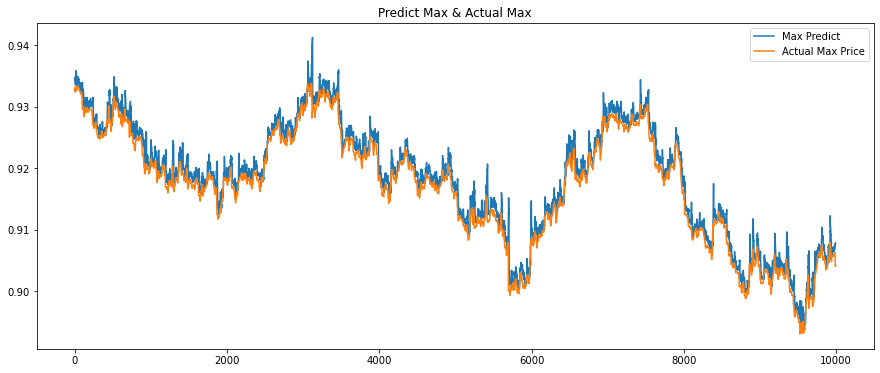

<Figure size 432x288 with 0 Axes>

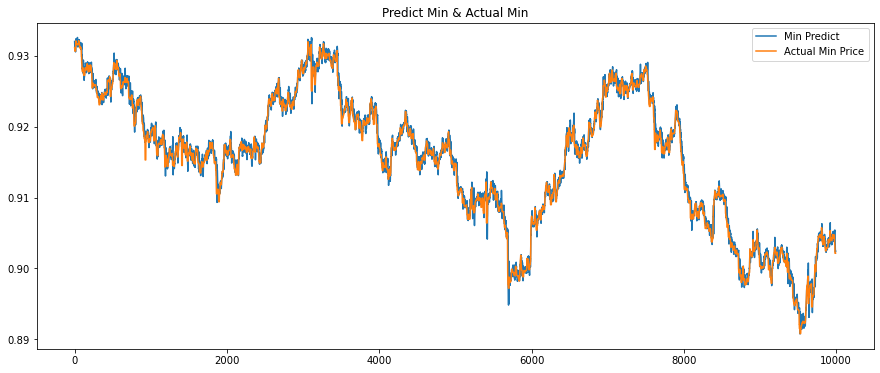

In [48]:

visualize_result(Bi_LSTM_Model,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)


In [49]:
Bi_LSTM_Model.save('bi_audcad_e30_b16_w10.h5')

# Transformer

In [63]:
def get_position_encoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0.2, mlp_dropout=0.2):

    input_ohlc = layers.Input((input_shape,4), dtype=tf.float32, name='OHLC')
    
    input_so1 = layers.Input((input_shape,), dtype=tf.int64, name='SO1')
    input_so2 = layers.Input((input_shape,), dtype=tf.int64, name='SO2')
    input_ma1 = layers.Input((input_shape,), dtype=tf.int64, name='MA1')
    input_ma2 = layers.Input((input_shape,), dtype=tf.int64, name='MA2')
    input_ma3 = layers.Input((input_shape,), dtype=tf.int64, name='MA3')
    input_ma4 = layers.Input((input_shape,), dtype=tf.int64, name='MA4')
    
    input_distance = layers.Input((input_shape,11), dtype=tf.float32, name='TAINDICATORS')
    # generate postional embedding
    positional_embedding = get_position_encoding(10,399)

    emb_so1 = layers.Embedding(6, 64, name='so1_embedding')(input_so1)
    emb_so2 = layers.Embedding(6, 64, name='so2_embedding')(input_so2)
    emb_ma1 = layers.Embedding(3, 64, name='ma1_embedding')(input_ma1)
    emb_ma2 = layers.Embedding(3, 64, name='ma2_embedding')(input_ma2)
    emb_ma3 = layers.Embedding(3, 64, name='ma3_embedding')(input_ma3)
    emb_ma4 = layers.Embedding(3, 64, name='ma4_embedding')(input_ma4)
    # INPUT EMBEDDING LAYER
    x = layers.Concatenate()([input_ohlc,emb_so1,emb_so2,emb_ma1,emb_ma2,emb_ma3,emb_ma4,input_distance])
    # combine the embedding matrix and postional embedding
    x = x+ positional_embedding
    x = layers.Dense(feat_dim)(x)

    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # pointwise mlp
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    output_maxp = layers.Dense(1, name='maxp')(x)
    output_minp = layers.Dense(1, name='minp')(x)
    # CLASSIFICATION 
    outputs_bhs = layers.Dense(1, activation="softmax", name='bhs')(x)
    model = keras.Model(inputs= [input_ohlc,input_so1,input_so2,input_ma1,input_ma2,input_ma3,input_ma4,input_distance], outputs=[output_maxp,output_minp,outputs_bhs])

    model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.01,decay = 0.001),
            loss={
                "maxp": 'mse',
                "minp":'mse',
                # categorical crossentropy 需要 one hot encoding
                # SparseCategoricalCrossentropy  label 输入为整数 
                'bhs' : 'categorical_crossentropy',
            },
            metrics={
                "maxp": tf.keras.metrics.RootMeanSquaredError(),
                "minp": tf.keras.metrics.RootMeanSquaredError(),
                'bhs' :'acc',
            }
        )

    return model

In [64]:
feat_dim = 256
embed_dim = 64  # Embedding size for attention
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.3
num_blocks = 2


transformer = build_model(10, embed_dim, num_heads, ff_dim, num_blocks, dropout=dropout_rate, mlp_dropout=0.2)
history = transformer.fit(train_x_dict, train_y_dict, 
          epochs=50, 
          batch_size=64,verbose = 1, validation_data=(valid_x_dict ,valid_y_dict) , shuffle = False)

Epoch 1/50
1250/1250 [==============================] - 80s 60ms/step - loss: 11.8208 - maxp_loss: 5.5503 - minp_loss: 6.2705 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 2.3559 - minp_root_mean_squared_error: 2.5041 - bhs_acc: 0.3983 - val_loss: 0.6439 - val_maxp_loss: 0.3007 - val_minp_loss: 0.3432 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5484 - val_minp_root_mean_squared_error: 0.5859 - val_bhs_acc: 0.3750
Epoch 2/50
1250/1250 [==============================] - 74s 59ms/step - loss: 0.7887 - maxp_loss: 0.3624 - minp_loss: 0.4262 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.6020 - minp_root_mean_squared_error: 0.6529 - bhs_acc: 0.3983 - val_loss: 0.6438 - val_maxp_loss: 0.3009 - val_minp_loss: 0.3428 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5486 - val_minp_root_mean_squared_error: 0.5855 - val_bhs_acc: 0.3750
Epoch 3/50
1250/1250 [==============================] - 71s 57ms/step - loss: 0.7886 - maxp_loss: 0.3624 - 

1250/1250 [==============================] - 63s 51ms/step - loss: 0.7886 - maxp_loss: 0.3623 - minp_loss: 0.4263 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.6019 - minp_root_mean_squared_error: 0.6529 - bhs_acc: 0.3983 - val_loss: 0.6439 - val_maxp_loss: 0.3010 - val_minp_loss: 0.3429 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5486 - val_minp_root_mean_squared_error: 0.5855 - val_bhs_acc: 0.3750
Epoch 20/50
1250/1250 [==============================] - 62s 50ms/step - loss: 0.7886 - maxp_loss: 0.3623 - minp_loss: 0.4263 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.6019 - minp_root_mean_squared_error: 0.6529 - bhs_acc: 0.3983 - val_loss: 0.6439 - val_maxp_loss: 0.3010 - val_minp_loss: 0.3429 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5487 - val_minp_root_mean_squared_error: 0.5855 - val_bhs_acc: 0.3750
Epoch 21/50
1250/1250 [==============================] - 63s 50ms/step - loss: 0.7886 - maxp_loss: 0.3623 - minp_loss:

1250/1250 [==============================] - 62s 50ms/step - loss: 0.7885 - maxp_loss: 0.3623 - minp_loss: 0.4262 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.6019 - minp_root_mean_squared_error: 0.6529 - bhs_acc: 0.3983 - val_loss: 0.6439 - val_maxp_loss: 0.3011 - val_minp_loss: 0.3428 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5487 - val_minp_root_mean_squared_error: 0.5855 - val_bhs_acc: 0.3750
Epoch 38/50
1250/1250 [==============================] - 63s 50ms/step - loss: 0.7885 - maxp_loss: 0.3623 - minp_loss: 0.4262 - bhs_loss: 0.0000e+00 - maxp_root_mean_squared_error: 0.6019 - minp_root_mean_squared_error: 0.6529 - bhs_acc: 0.3983 - val_loss: 0.6439 - val_maxp_loss: 0.3011 - val_minp_loss: 0.3428 - val_bhs_loss: 0.0000e+00 - val_maxp_root_mean_squared_error: 0.5487 - val_minp_root_mean_squared_error: 0.5855 - val_bhs_acc: 0.3750
Epoch 39/50
1250/1250 [==============================] - 63s 51ms/step - loss: 0.7885 - maxp_loss: 0.3623 - minp_loss:

In [65]:
transformer.save('transformer_audcad_epo50_bs64.h5')

313/313 [==============================] - 3s 9ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01058841
Mean Absolute Percentage Error: 1.15493883
Mean Square Error: 0.00017360
Root Mean Square Error: 0.01317563

Model:
Mean Absolute Error: 0.01059381
Mean Absolute Percentage Error: 1.16031100
Mean Square Error: 0.00017377
Root Mean Square Error: 0.01318235

Accuracy for predicting buy hold sell label: 0.3152
              precision    recall  f1-score   support

           0       0.32      1.00      0.48      3149
           1       0.00      0.00      0.00      3747
           2       0.00      0.00      0.00      3095

   micro avg       0.32      0.32      0.32      9991
   macro avg       0.11      0.33      0.16      9991
weighted avg       0.10      0.32      0.15      9991
 samples avg       0.32      0.32      0.32      9991

----------------------------

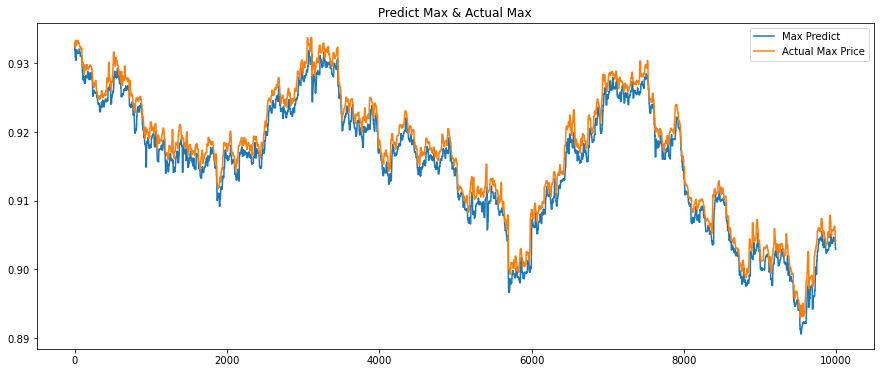

<Figure size 432x288 with 0 Axes>

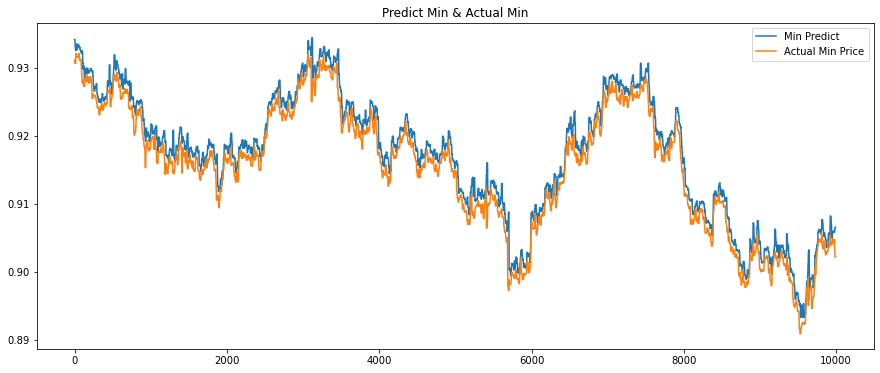

In [66]:
from keras.models import load_model
transformer2= load_model('transformer_audcad_epo50_bs64.h5')
visualize_result(transformer2,valid_x_dict,valid_y_dict,val_price_scaler_max,val_price_scaler_min,valid_minprice, valid_maxprice)